The goal for running tractor is to find the ideal model of a galaxy using (a combination of) cersic, exponential, and de Vaucouleurs models. In order to do this, we need to:
- create a tractor image (which is a model of the galaxy) using the following models:
    - exponential
    - de Vaucouleurs
    - composites    
- take the model and compare it to the DECaLs model

In [1]:
%matplotlib inline

import os
import copy

import fitsio
import numpy as np
import pylab as plt


from astropy.io import fits
from astropy.wcs import WCS
from astropy.table import Table

import sep
import tractor

from astrometry.util.fits import fits_table
#from astrometry.util.util import wcs_pv2sip_hdr

from tractor import NullWCS
from tractor.galaxy import *
from tractor.sersic import *
from tractor.psf import *
from tractor.ellipses import *

In [2]:
def fit_galaxies (galaxy_type, cat):
    #galaxy type: 
    # - "comp" = composite 
    # - "dev" = de Vaucouleurs 
    # - "ser" = sersic 
    # - "exp" = exponential 
    
    sources = []
    
    if galaxy_type == 'comp':
        for obj in obj_cat_bright:
            # if the object is a point source, add it as such
            if obj['point_source'] > 0.0:
                sources.append(tractor.PointSource(tractor.PixPos(obj['x'], obj['y']),
                                                   tractor.Flux(obj['flux'])) )
            else:
                sources.append(tractor.CompositeGalaxy(PixPos(obj['x'], obj['y']), 
                                                       Flux(0.4 * obj['flux']), GalaxyShape(obj['a'] * 0.8,  0.9,  obj['theta'] * 180.0 / np.pi),
                                                       Flux(0.6 * obj['flux']), GalaxyShape(obj['a'],  obj['b']/obj['a'], obj['theta'] * 180.0 / np.pi)))
    elif galaxy_type == 'dev':
        for obj in obj_cat_bright:
            # if the object is a point source, add it as such
            if obj['point_source'] > 0.0:
                sources.append(tractor.PointSource(tractor.PixPos(obj['x'], obj['y']),
                                                   tractor.Flux(obj['flux'])) )
            else:
                sources.append(tractor.DevGalaxy(tractor.PixPos(obj['x'], obj['y']),
                                         tractor.Flux(obj['flux']),
                                         GalaxyShape(obj['a'] / 2.0, 
                                                     (obj['b'] / obj['a']),
                                                     (180.0 - obj['theta'] * 180.0 / np.pi))))
    elif galaxy_type == 'exp':
        for obj in obj_cat_bright:
            # if the object is a point source, add it as such
            if obj['point_source'] > 0.0:
                sources.append(tractor.PointSource(tractor.PixPos(obj['x'], obj['y']),
                                                   tractor.Flux(obj['flux'])) )
            else:
                sources.append(tractor.ExpGalaxy(tractor.PixPos(obj['x'], obj['y']),
                                                    tractor.Flux(obj['flux']),
                                                    GalaxyShape(obj['a'] / 2.0, 
                                                                (obj['b'] / obj['a']),
                                                                (180.0 - obj['theta'] * 180.0 / np.pi))))
    else: 
        raise ValueError('incorrect input for galaxy type')
        # valid types: 'comp' , 'dev' , 'exp'
                
                
    return sources         
                
    

In [3]:
#open fits files
num = '26'
galaxy_dir = os.path.dirname(os.path.abspath(num+'_tractor_ready'))
path = os.path.join(galaxy_dir,num+'_tractor_ready')

img_data = fits.open(os.path.join(path,'img_data_crop_'+num+'.fits'))[0].data
psf_data = fits.open(os.path.join(path,'psf_data_crop_'+num+'.fits'))[0].data
psf_obj = tractor.PixelizedPSF(psf_data, Lorder=5)
sig_data = fits.open(os.path.join(path,'sig_data_crop_'+num+'.fits'))[0].data

obj_cat = Table.read(path+'/tractor_'+num+'.fits')

invvar_data = (1.0 / (sig_data ** 2.0))

w = NullWCS(pixscale=0.168)

In [4]:
tim = tractor.Image(data=img_data,
            invvar=invvar_data,
            psf=psf_obj,
            wcs=w,
            sky=tractor.ConstantSky(0.0),
            photocal=tractor.NullPhotoCal()
            )

In [5]:
obj_cat_bright = copy.deepcopy(obj_cat) 
obj_cat_bright.sort('flux')
obj_cat_bright.reverse()

obj_cat_bright = obj_cat_bright[:20]

In [6]:
sources_comp = fit_galaxies('comp',obj_cat_bright)
sources_dev = fit_galaxies('dev',obj_cat_bright)
sources_exp = fit_galaxies('exp',obj_cat_bright)
sources_ser = fit_galaxies('ser',obj_cat_bright)

In [7]:
trac_obj_comp = Tractor([tim], sources_comp)
trac_mod_comp = trac_obj_comp.getModelImage(0, minsb=0.0)

trac_obj_dev = Tractor([tim], sources_dev)
trac_mod_dev = trac_obj_dev.getModelImage(0, minsb=0.0)

trac_obj_exp = Tractor([tim], sources_exp)
trac_mod_exp = trac_obj_exp.getModelImage(0, minsb=0.0)

trac_obj_ser = Tractor([tim],sources_ser)
trac_mod_ser = trac_obj_ser.getModelImage(0, minsb=0.0)

In [8]:
# de vac function
trac_obj_dev.freezeParam('images')
trac_obj_dev.optimize_loop()

trac_mod_opt = trac_obj_dev.getModelImage(0, minsb=0., srcs=sources_dev)

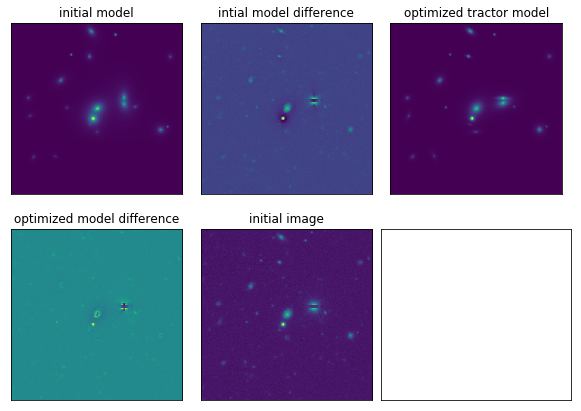

In [9]:
fig, axarr = plt.subplots(2,3)
axarr[0,0].imshow(np.arcsinh(trac_mod_dev))
axarr[0,0].set_title('initial model')
#plt.show()
axarr[0,1].imshow(np.arcsinh(img_data - trac_mod_dev))
axarr[0,1].set_title('intial model difference')
#plt.show()
axarr[0,2].imshow(np.arcsinh(trac_mod_opt))
axarr[0,2].set_title('optimized tractor model')
#plt.show()
axarr[1,0].imshow(np.arcsinh(img_data - trac_mod_opt))
axarr[1,0].set_title('optimized model difference')
#plt.show()
axarr[1,1].imshow(np.arcsinh(img_data))
axarr[1,1].set_title('initial image')
#plt.show()

fig.tight_layout(rect=[0, 0, 1.5, 1.5])
plt.subplots_adjust(wspace=0, hspace=.2)
fig.frameon = False

axes = [axarr[0,0],axarr[0,1],axarr[0,2],axarr[1,0],axarr[1,1],axarr[1,2]]
for ax in axes:
        ax.set_xticks([])
        ax.set_yticks([])
        

In [10]:
# exp function
trac_obj_exp.freezeParam('images')
trac_obj_exp.optimize_loop()

trac_mod_opt = trac_obj_exp.getModelImage(0, minsb=0., srcs=sources_exp)

patchx is None:
   ExpGalaxy at pixel (782.04, 79.49) with Flux: 203.092 and Galaxy Shape: re=50.51, ab=69.44, phi=163.1
  stepping galaxy shape re
  stepped 1.0
  to 50.5080721793
patchx is None:
   ExpGalaxy at pixel (782.04, 79.49) with Flux: 203.092 and Galaxy Shape: re=50.51, ab=69.44, phi=163.1
  stepping galaxy shape ab
  stepped 1.0
  to 69.4390812382
patchx is None:
   ExpGalaxy at pixel (782.04, 79.49) with Flux: 203.092 and Galaxy Shape: re=50.51, ab=69.44, phi=163.1
  stepping galaxy shape phi
  stepped 1.0
  to 163.084888514
patchx is None:
   ExpGalaxy at pixel (782.04, 79.49) with Flux: 2922.28 and Galaxy Shape: re=50.51, ab=69.44, phi=163.1
  stepping galaxy shape re
  stepped 1.0
  to 50.5080721793
patchx is None:
   ExpGalaxy at pixel (782.04, 79.49) with Flux: 2922.28 and Galaxy Shape: re=50.51, ab=69.44, phi=163.1
  stepping galaxy shape ab
  stepped 1.0
  to 69.4390812382
patchx is None:
   ExpGalaxy at pixel (782.04, 79.49) with Flux: 2922.28 and Galaxy Shape: re=

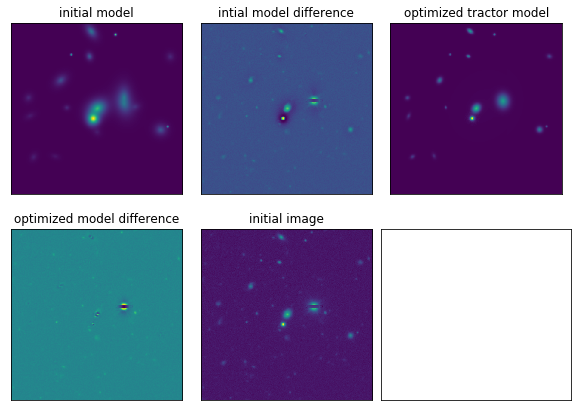

In [11]:
fig, axarr = plt.subplots(2,3)
axarr[0,0].imshow(np.arcsinh(trac_mod_exp))
axarr[0,0].set_title('initial model')
#plt.show()
axarr[0,1].imshow(np.arcsinh(img_data - trac_mod_exp))
axarr[0,1].set_title('intial model difference')
#plt.show()
axarr[0,2].imshow(np.arcsinh(trac_mod_opt))
axarr[0,2].set_title('optimized tractor model')
#plt.show()
axarr[1,0].imshow(np.arcsinh(img_data - trac_mod_opt))
axarr[1,0].set_title('optimized model difference')
#plt.show()
axarr[1,1].imshow(np.arcsinh(img_data))
axarr[1,1].set_title('initial image')
#plt.show()

fig.tight_layout(rect=[0, 0, 1.5, 1.5])
plt.subplots_adjust(wspace=0, hspace=.2)
fig.frameon = False

axes = [axarr[0,0],axarr[0,1],axarr[0,2],axarr[1,0],axarr[1,1],axarr[1,2]]
for ax in axes:
        ax.set_xticks([])
        ax.set_yticks([])
        

In [12]:
# composite function
trac_obj_comp.freezeParam('images')
trac_obj_comp.optimize_loop()

trac_mod_opt = trac_obj_comp.getModelImage(0, minsb=0., srcs=sources_comp)

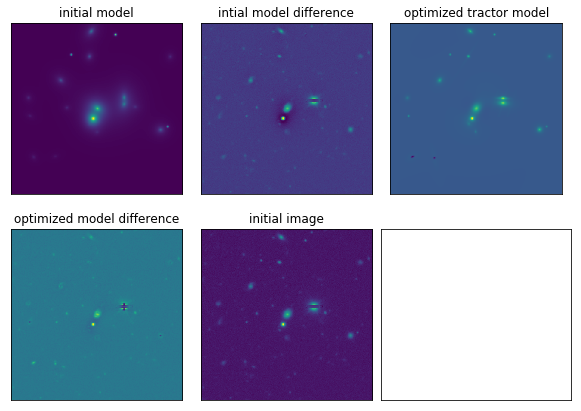

In [13]:
fig, axarr = plt.subplots(2,3)
axarr[0,0].imshow(np.arcsinh(trac_mod_comp))
axarr[0,0].set_title('initial model')
#plt.show()
axarr[0,1].imshow(np.arcsinh(img_data - trac_mod_comp))
axarr[0,1].set_title('intial model difference')
#plt.show()
axarr[0,2].imshow(np.arcsinh(trac_mod_opt))
axarr[0,2].set_title('optimized tractor model')
#plt.show()
axarr[1,0].imshow(np.arcsinh(img_data - trac_mod_opt))
axarr[1,0].set_title('optimized model difference')
#plt.show()
axarr[1,1].imshow(np.arcsinh(img_data))
axarr[1,1].set_title('initial image')
#plt.show()

fig.tight_layout(rect=[0, 0, 1.5, 1.5])
plt.subplots_adjust(wspace=0, hspace=.2)
fig.frameon = False

axes = [axarr[0,0],axarr[0,1],axarr[0,2],axarr[1,0],axarr[1,1],axarr[1,2]]
for ax in axes:
        ax.set_xticks([])
        ax.set_yticks([])
        